# DID REDDITORS INFLUENCE CREDIT SUISSE COLLAPSE?
This research aims to determine if the Reddit financial community had had any power in the decline of Credit Suisse's stocks price. It has been conducted as a sentiment analysis of Reddit's posts, using Python, NLP and machine learning techniques

## 0. Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
import os
import emoji

from PIL import Image
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, QuadgramAssocMeasures
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from gensim.models import Word2Vec

def pretty_print(df):
    print('First 5 posts:')
    for i in df.index[0:5]:
        txt = str(i+1) + '. ' + df.loc[i, 'text']
        if len(txt) > 115:
            print(txt[0:115] + '...')
        else:
            print(txt)

## 1. Exploratory Analysis
All Reddit posts containing the words 'Credit Suisse' were downloaded from Reddit API. In this way, 4699 posts were extracted with the following features:
* title: title of the post
* post_id: unique code of the post
* date: date in which the post was published
* karma: the equivalent of the 'Like' button
* upvote: the ratio between positive and total karma
* content: content of the post. It can be NaN if it is a video or an image
* subreddit: subreddit (Reddit threads) were the post was published

In [ ]:
# Import the dataset
df = pd.read_csv('Rawdata.csv', index_col = 0)
df.head()

,title,post_id,date,karma,upvote,content,subreddit
0,I thought of you guys when I listened to this ...,ek5jql,2020-01-05 00:58:56,0,0.50,Bloomberg View columnist Barry Ritholtz interv...,algotrading
1,Historical analyst target prices,gtz5kk,2020-05-31 13:36:45,0,0.33,Analysts' stock reports from investment banks ...,algotrading
2,The Swiss government just borrowed $9 billion ...,y83ebs,2022-10-19 13:55:33,3431,0.95,NaN,amcstock
3,"REALITY CHECK: Peter Hahn, one of the major fi...",xuht8x,2022-10-03 12:15:15,1957,0.89,I think it's important for us to manage expect...,amcstock
4,*** Ultimate AMC Timeline (Updated April 25) ***,mygdc3,2021-04-25 20:05:47,2756,0.99,# [CLICK HERE to go to the April 28 update.](h...,amcstock


### 1.1 Removing unrelevant posts
From the 4699 posts downloaded we extract only those which are relevant for the purposes of the analysis. Indeed, the period considered goes from 01/08/2022 (2 months before the first drop of Credit Suisse stock) to 20/03/2023 (when Credit Suisse was took over by UBS). Moreover, the posts that are solely reporting news were removed from the corpus, because they do not carry opinions. Finally, Reddit posts are made of a title and a text. For the sake of simplicity they were joined in a single element.

In this way, only 1511 observations remain in the dataset.

In [ ]:
# Join title and text
df.fillna('', inplace=True)
df['text'] = df['title'] + ' ' + df['content']
df.drop(['title', 'content'], axis=1, inplace=True)
df['karma'] += 1

# Filter for period: 01/08/2022 - 20/03/2023
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] > pd.to_datetime('2022-08-01')].copy()
df = df[df['date'] < pd.to_datetime('2023-03-20')].copy()
df.reset_index(drop=True, inplace=True)

# Remove stock news post
forbidden_words = ['CLICK HERE', 'Downgrades:', 'volume leaders', 'Q4 2022 Letters & Reports', 'Holdings Inc']
to_save = ['11ushdl', 'zt4t1y', 'yckj9o', 'ybqjek']
to_drop = []
for i in df.index:
    for forbidden in forbidden_words:
        if forbidden in df.loc[i, 'text']:
            if df.loc[i, 'post_id'] not in to_save:
                to_drop.append(i)

df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
pretty_print(df)

First 5 posts:
1. The Swiss government just borrowed $9 billion from the U.S. Federal Reserve to bail out Credit Suisse. 
2. REALITY CHECK: Peter Hahn, one of the major figures pushing the Credit Suisse failure (and is an absolute genius...
3. Again, “smart money” does not care about retail(us) when they’re making money and taking from us. They have a lo...
4. Good news 
5. Which one of you mean APES mocked Credit Suisse…comon, own up!…. 


### 1.2 Dataset exploration
The posts have different lengths, even if the majority of them have few words (less than 100).

Concerning the period, there are two peaks of activity (high volume of posts): October 2022 and March 2023 when Credit Suisse stock prices fell down (eventually, in March 2023 the company was tookover by UBS).

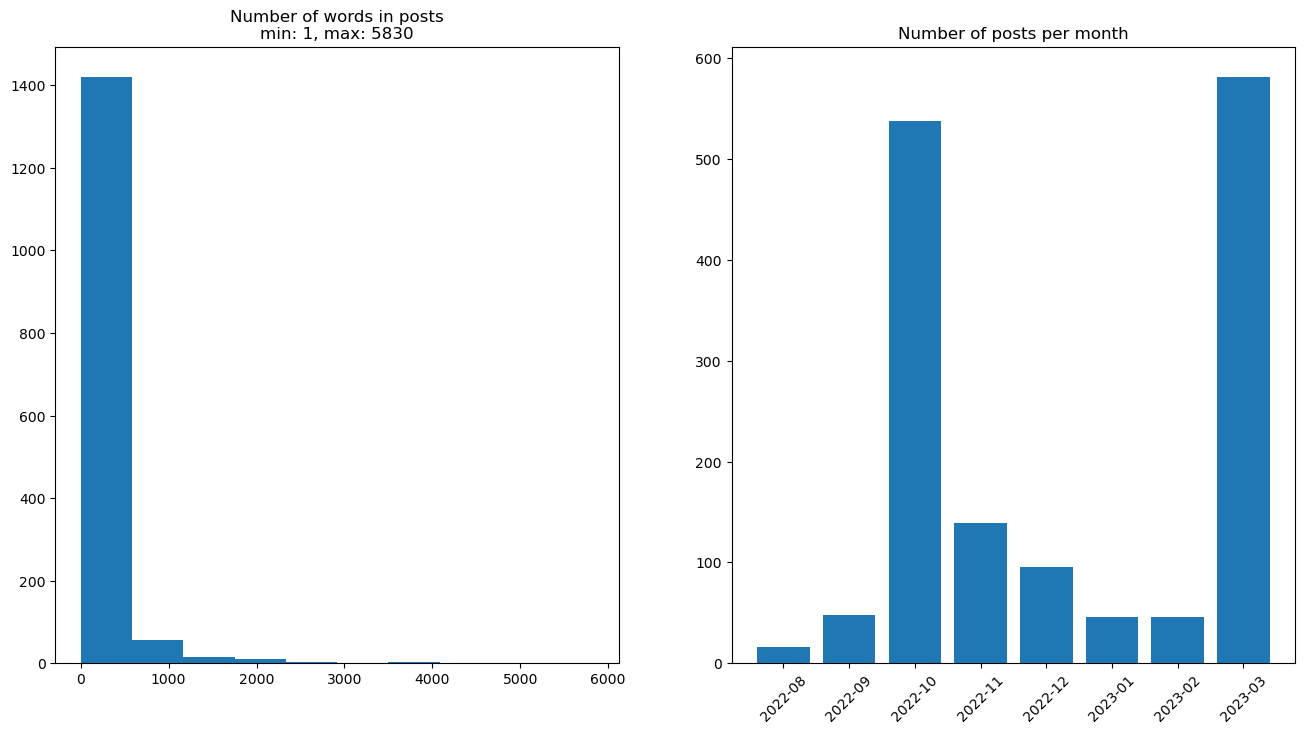

In [ ]:
# Number of words in posts and number of posts per month
df['length'] = 0
for i in df.index:
    df.loc[i, 'length'] = len(df.loc[i, 'text'].split())
periodo = df['date'].dt.strftime('%Y-%m').value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(df['length'])
ax[0].set_title(f'Number of words in posts\nmin: {df["length"].min()}, max: {df["length"].max()}')
ax[1].bar(periodo.index, periodo)
ax[1].set_title('Number of posts per month')
ax[1].set_xticks(np.arange(8))
ax[1].set_xticklabels(periodo.index, rotation=45)
plt.show()

## 2. Data Preparation
In order to be analyzed, textual data must be processed in various ways. Indeed, techniques such as word_embedding or sentiment extraction rely on high quality data, whitout unrelevant elements.

4 steps were followed:
* Emoji translation: translation from symbols to litteral words
* Text pre-processing: removal of special characters
* Sentiment extraction: assignment of a sentiment score to each post
* Natural Language Processing: removal of unrelevant elements and words

All the emojis were stored in a specific feature ('emojis') and translated to their litteral meaning: 💪 --> 'flexed biceps'.

In [ ]:
# Emoticon extraction
df['emojis'] = ''
for i in df.index:
    df.loc[i, 'emojis'] = ' '.join([emoji.demojize(c).replace(':', '').replace('_', ' ') for c in df.loc[i, 'text'] if c in emoji.EMOJI_DATA])
df['emojis'][df['emojis'] != '']

2                            flexed biceps hundred points
11                                                gorilla
12                                              fire fire
13                                                   eyes
17      gorilla flexed biceps gorilla flexed biceps go...
                              ...                        
1451                                                 fire
1457                                                 frog
1468                                                 fire
1470         classical building houses classical building
1473                classical building classical building
Name: emojis, Length: 221, dtype: object

### 2.1 Text pre-processing
The next step is removing from the posts all the special characters such as symbols, numbers, punctuation marks, hashtag, mentions, links and usernames. In this way, only words remain.

In [ ]:
## Preparing data for the analysis
for i in df.index:
    text = df.loc[i, 'text']
    whole = []
    for element in sent_tokenize(text):
        clean = element.lower()
        clean = re.sub(r'\bcs\b', 'credit suisse', clean)
        clean = re.sub(r'\bdd\b', 'double down', clean)
        clean = re.sub(r'\bcds\b', 'default swap', clean)
        clean = re.sub(r'u\.s\.', 'usa', clean)
        clean = re.sub(r'&#[A-Za-z0-9]+', '', clean)
        clean = re.sub(r'tl(;|)dr', '', clean)
        clean = re.sub(r'\([^()]*\)', '', clean)
        clean = re.sub(r'\[[^\[\]]*\]', '', clean)
        clean = re.sub(r"(?:\@|http?|https?|www)\S+", "", clean)
        clean = re.sub(r'\’', "'", clean)
        clean = re.sub(r"[^A-Za-z\']", ' ', clean)
        clean = re.sub(r'\b\w\b', '', clean)
        clean = re.sub(r'\bcredit\b', '', clean)
        wo_spaces = clean.split()
        clean = ' '.join(wo_spaces)
        whole.append(clean)
    clean = '. '.join(whole)
    df.loc[i, 'text'] = clean
pretty_print(df)

First 5 posts:
1. the swiss government just borrowed billion from the usa federal reserve to bail out suisse
2. reality check peter hahn one of the major figures pushing the suisse failure also said that moass could be pushe...
3. again smart money does not care about retail when they're making money and taking from us. they have lot to lose...
4. good news
5. which one of you mean apes mocked suisse comon own up


### 2.2 Sentiment scores computing
Sentiment scores are computed using VADER algorithm: each word of a specific post is assigned to a sentiment score (for example, 'love' = +0.5; 'collapse' = -0.6), and then, all the scores are aggregated in a single sentiment measure. This measure ranges from +1 (positive) to -1 (negative), while 0 indicates neutrality.

Redditors lexicon is characterized by lot of slang. VADER algorithm, instead, was trained on Twitter data, so, this can represent a source of low accuracy (posts that are postive or negative are labeled as neutral).

The months with the lowest aggregate sentiment scores are the same of Credit Suisse stock prices collapse: October 2022 and March 2023. Therefore, at first sight, there may be a relationship between Credit Suisse stock prices and activity on Reddit. Nevertheless, it can be the case of reverse causality: the shock in stock prices represents an important event to be commented online.

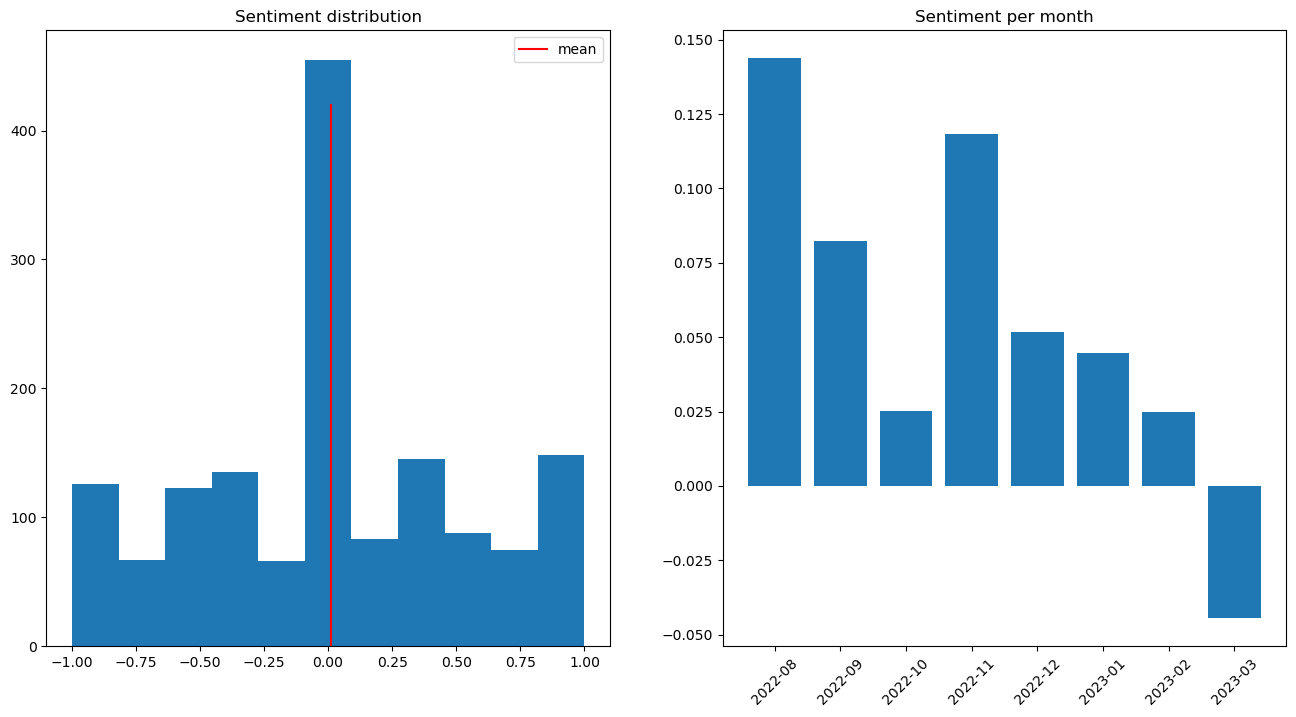

In [ ]:
# Computing sentiment scores
sia = SentimentIntensityAnalyzer()
sentiment_scores = [sia.polarity_scores(doc)['compound'] for doc in df['text'] + ' ' + df['emojis']]
df['sentiment'] = sentiment_scores
df.to_csv('Processeddata.csv')

# Frequency distribution and monthly distribution of sentiment
df['periodo'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
periodo = df[['periodo', 'sentiment']].groupby('periodo').mean()
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].hist(sentiment_scores, bins=11)
ax[0].plot([np.mean(sentiment_scores), np.mean(sentiment_scores)], [0, 420], color='red')
ax[0].set_title('Sentiment distribution')
ax[0].legend(['mean'])
ax[1].bar(np.arange(8), periodo.values.ravel())
ax[1].set_title('Sentiment per month')
ax[1].set_xticks(np.arange(8))
ax[1].set_xticklabels(periodo.index, rotation=45)
plt.show()

### 2.3 Natural laguage pre-processing
There are three main NLP techniques
* tokenization: the words in a post are divided in tokens (units)
* lemmatization: each word is brought back to its lemma: 'rocks' --> 'rock'; 'banking' --> 'bank'
* stopwords removal: stopwords are common words such as articles, prepositions, pronouns. The list of stopwords was extended with some words that are common to all the posts and do not carry any relevant information or opinion, such as 'Credit Suisse', 'bank', 'stock', 'click', ...

In [ ]:
df = pd.read_csv('Processeddata.csv', index_col=0)
df.fillna('', inplace=True)

# Tokenizing, removing stopwords, lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

lemmatizer = WordNetLemmatizer()
stop_words_list = stopwords.words("english")
more_stopwords = ['credit', 'suisse', 'bank', 'stock', 'click', 'chart', 'market',
                  'link', 'tgt', 'price', 'swiss', 'amc', 'ape', 'gme', 'upgrade', 'downgrade',
                  'upgraded', 'downgraded', 'outperform', 'underperform', 'perform',
                  'overweight', 'equal', 'weight', 'underweight', 'neutral', 'jp', 'morgan',
                  'minute', 'topaz', 'meltzer', 'sc', 'basket']
less_stopwords = ['not', 'no', 'nor', 'up', 'down', 'out']
stop_words_list.extend(more_stopwords)
untouchable = ['moass', 'usa']
for word in less_stopwords:
    stop_words_list.remove(word)
stop_words = set(stop_words_list)

empties = []
for i in df.index:
    clean = df.loc[i, 'text']
    clean = re.sub(r"[^A-Za-z]", ' ', clean)
    tokens = word_tokenize(clean)
    pos = pos_tag(tokens)
    filtered_post = []
    for word in pos:
        if word[0] not in untouchable:
            lemm = lemmatizer.lemmatize(word[0], pos=get_wordnet_pos(word[1]))
        else:
            lemm = word[0]
        if lemm not in stop_words:
            filtered_post.append(lemm)
    clean = ' '.join(filtered_post)
    wo_spaces = clean.split()
    clean = ' '.join(wo_spaces)
    if clean.strip() == '':
        empties.append(i)
    df.loc[i, 'text'] = clean
df.drop(empties, inplace=True)
df.reset_index(drop=True, inplace=True)

## Saving processed dataframe
df.to_csv('Sentdata.csv')
pretty_print(df)

First 5 posts:
1. government borrow billion usa federal reserve bail out
2. reality check peter hahn one major figure push failure also say moass could push out another year interview bigg...
3. smart money not care retail make money take u lot lose make hodl even strong
4. good news
5. one mean mock comon up


## 3. Analysis
There are mainly two types of analysis carried out in this research:
* textual analysis: analysis of words
* financial analysis: analysis of Credit Suisse financial data

In [ ]:
def StandScal(df):
    for col in df.columns:
        if df[col].dtype != 'O':
            mean = df[col].dropna().mean()
            std = df[col].dropna().std()
            for i in df.index:
                if not np.isnan(df.loc[i, col]):
                    df.loc[i, col] = (df.loc[i, col]-mean)/std
                else:
                    continue
    return df

### 3.1 Words frequency
4 Wordclouds are presented for 4 types of collocations, i.e., combination of one or more words that frequently appear together: Unigram (single words), Bi-grams, Tri-grams, Quad-grams.

In [ ]:
## WordCloud for each subset and collocation

# Converting collocations to single units
def tuple_keys_to_unique_strings(dictionary):
    new_dict = {}
    for key_tuple, value in dictionary.items():
        new_key = ' '.join(key_tuple)
        new_dict[new_key] = value
    return new_dict

corpus = word_tokenize(' '.join([df.loc[i, 'text'] for i in df.index]))
image_path = os.path.join("circle.png")
image = Image.open(image_path)
imask = np.array(image)

#### Unigrams (single words)
Concerning single words frequency, there are no remarkable results. The most common words are normal words with no specific opinion or sentiment.

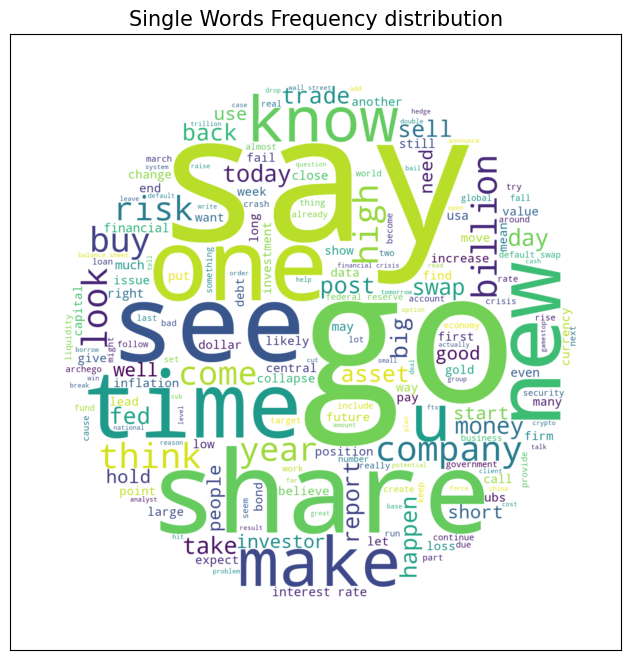

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1)
wordcloud.generate(' '.join(corpus))
ax.set_title('Single Words Frequency distribution', fontsize = 15)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Bi-grams (2-words combination)
Concerning bigrams there are notable combinations:
* 'default swap': default swap are insurances against financial default of a company. One way to speculate against a company is buying and pumping the price of default swap.
* 'financial crisis': the fall of Credit Suisse (together with Silicon Valley Bank and Signature Bank defaults) were associated to 2008 financial crisis
* 'double down': in gambling term to double down means to double the money risked. Figuratively means to go on gambling, betting.
* 'margin call': margin calls are deposits given from investors to brokers to cover possible losses, expecially when short selling
* 'naked short': naked shorting is a short selling strategy where the investors sell securities that he hasn't purchased yet. This creates artificial pressure on the stock price.

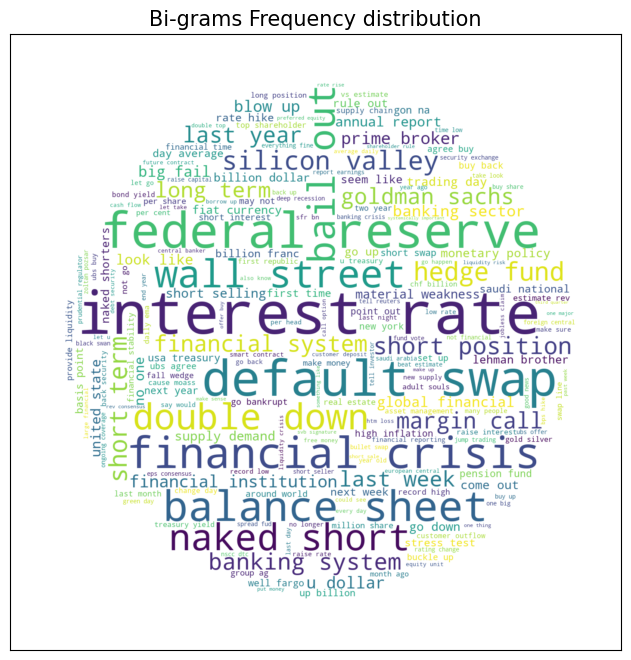

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
finder = BigramCollocationFinder.from_words(corpus)
fdist = finder.score_ngrams(BigramAssocMeasures().raw_freq)
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1)
wordcloud.generate_from_frequencies(tuple_keys_to_unique_strings(dict(fdist)))
ax.set_title('Bi-grams Frequency distribution', fontsize=15)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Tri grams (3-words combination)
Concerning trigrams there are no remarkable combinations except for those which already appear on the Bi-grams wordcloud.

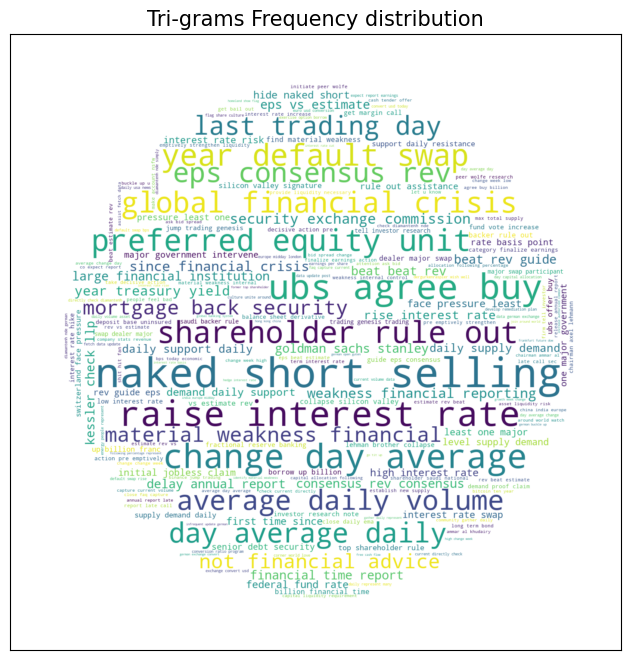

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
finder = TrigramCollocationFinder.from_words(corpus)
fdist = finder.score_ngrams(TrigramAssocMeasures().raw_freq)
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1)
wordcloud.generate_from_frequencies(tuple_keys_to_unique_strings(dict(fdist)))
ax.set_title('Tri-grams Frequency distribution', fontsize=15)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

#### Quad grams (4-words combination)
Concerning trigrams there are no remarkable combinations except for those which already appear on the Bi-grams wordcloud.

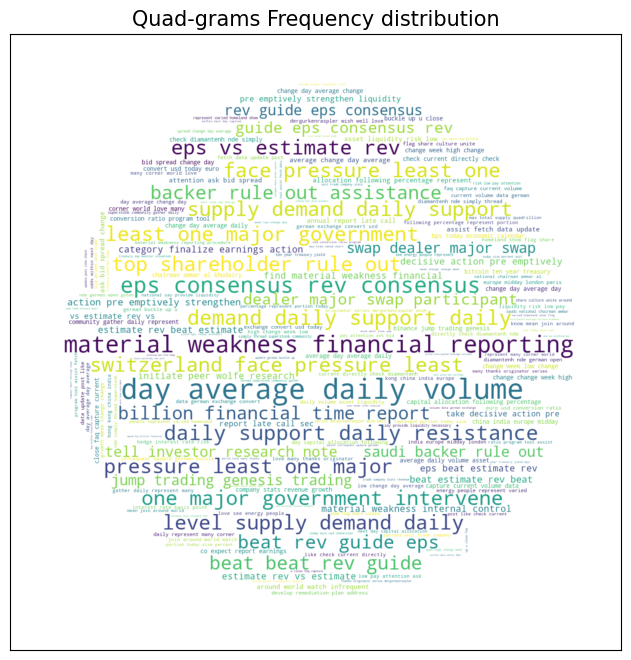

In [ ]:
fig, ax = plt.subplots(figsize = (16,8))
finder = QuadgramCollocationFinder.from_words(corpus)
fdist = finder.score_ngrams(QuadgramAssocMeasures().raw_freq)
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1)
wordcloud.generate_from_frequencies(tuple_keys_to_unique_strings(dict(fdist)))
ax.set_title('Quad-grams Frequency distribution', fontsize=15)
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### 3.2 Sentiment Analysis
Sentiment analysis refers to the study of the sentiment of the post. In this case it was investigated the realtionship between redditor's sentiment and Credit Suisse stock prices. Since posts are posted every second while the stock prices have a daily frequence, the daily sentiment was computed as the mean of the sentiment of all the posts published in that specific day. This causes two problems: a) reduction of dimensions (from 1511 observation to just 134) and b) loss of the information carried by post published during the weekend (when the stocks are not traded).

#### Linear Correlation between sentiment and stock returns
the daily sentiment expressed on reddit is correlated (OLS multiple regression) against the stock price daily returns. Other explanatory variables are the amount, length, karma and upvote ratio of the posts. In other words, the information extracted from the posts are correlated against the financial behaviour of Credit Suisse.

The results are very bad: the R2 is close to 0 meaning none explanantory power of this model and the only significant variable is the number of posts. This can be due to several reasons:
1. the sentiment feature was computed using an automatic sentiment extractor (Vader algorithm) trained on twitter data. It can be the case that the polarity score assigned to each post does not reflect the true sentiment of the post.
2. the little amount of data, combined with the loss of information from weekend posts.
3. the relationship is not linear.
4. there is no relationship at all between sentiment and stock returns

Clearly, we do not surrend to hypothesis 4 yet. Regarding 1. and 2. improving the quality of data would require an enormous time-consuming activity, in order to a) label manually the sentiment of the post and b) find a way to recover the loss of data. So, in the next section we investigate hypothesis no. 3.

In [ ]:
# Regression setting
X = daily[['sentiment', 'length', 'posts', 'karma', 'upvote']]
X = sm.add_constant(X)
Y = daily['returns']
reg = sm.OLS(Y, X)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.399
Date:                Sun, 03 Sep 2023   Prob (F-statistic):              0.229
Time:                        13:21:00   Log-Likelihood:                 228.51
No. Observations:                 134   AIC:                            -445.0
Df Residuals:                     128   BIC:                            -427.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0108      0.032     -0.340      0.7

#### KNearestNeighbours
Following from results of the previous analysis, we are interested in studying if at least the direction of the stock price movement (price up or price down) can be explained by the information extracted by Reddit posts. We set up a KNearestNeighbour model where the explanatory variables are the same as before (sentiment, length, number of posts, karma and upvote) while the target variable is a dummy that takes value 0 if the price has decreased from the previous day or 1 if it has increased.

The parameter of the model, K, the number of nearest neighbours to observe in order to label the target observation, is chosen by cross validation. The dataset was divided in two sets, train set (the posts made in 2022), test set (the posts made in 2023). This division seems a good compromise between train size and risk of overfitting. Moreover the train set comprehend 3 of the 4 peaks previously identified, while the test comprehend the last peak, the biggest and more anomalous one. Therefore, fitting the model on the train set several times and chosing a different K at each iteration (from 1 to 51), we compute each score by comparing the true values of the test set and the ones predicted by the model. Eventually, we choose the model with best score.

The best model is the one with K=39 and it has a score of 0.66. This is quite high and it can indicate a relationship between sentiment and stock price movement.

In [ ]:
dataset = StandScal(daily)
dataset['returns'] = dataset['returns']>=0
dataset['date'] = pd.to_datetime(dataset['date'])
train = dataset[dataset['date']<pd.to_datetime('2023-01-01')]
test = dataset[dataset['date']>=pd.to_datetime('2023-01-01')]
X_train = train[['posts', 'karma', 'upvote', 'length', 'sentiment']].values
Y_train = train['returns'].values
X_test = test[['posts', 'karma', 'upvote', 'length', 'sentiment']].values
Y_test = test['returns'].values

scores = []
for k in np.arange(3, 52, 2):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    scores.append(knn.score(X_test, Y_test))
print('K optimal:', np.arange(3, 52, 2)[np.argmax(scores)], '\nScore:', np.max(scores))

K optimal: 39 
Score: 0.6666666666666666


### 3.3 Post traffic analysis
The term traffic analysis refers to the study of the number of posts published in a certain period. Considering the time horizon chosen, it is possible to identify 4 peaks of activity: 3rd October 2022, 27th October 2022, 23th November 2022 and 15th March 2023 (Credit Suisse definitive decline).

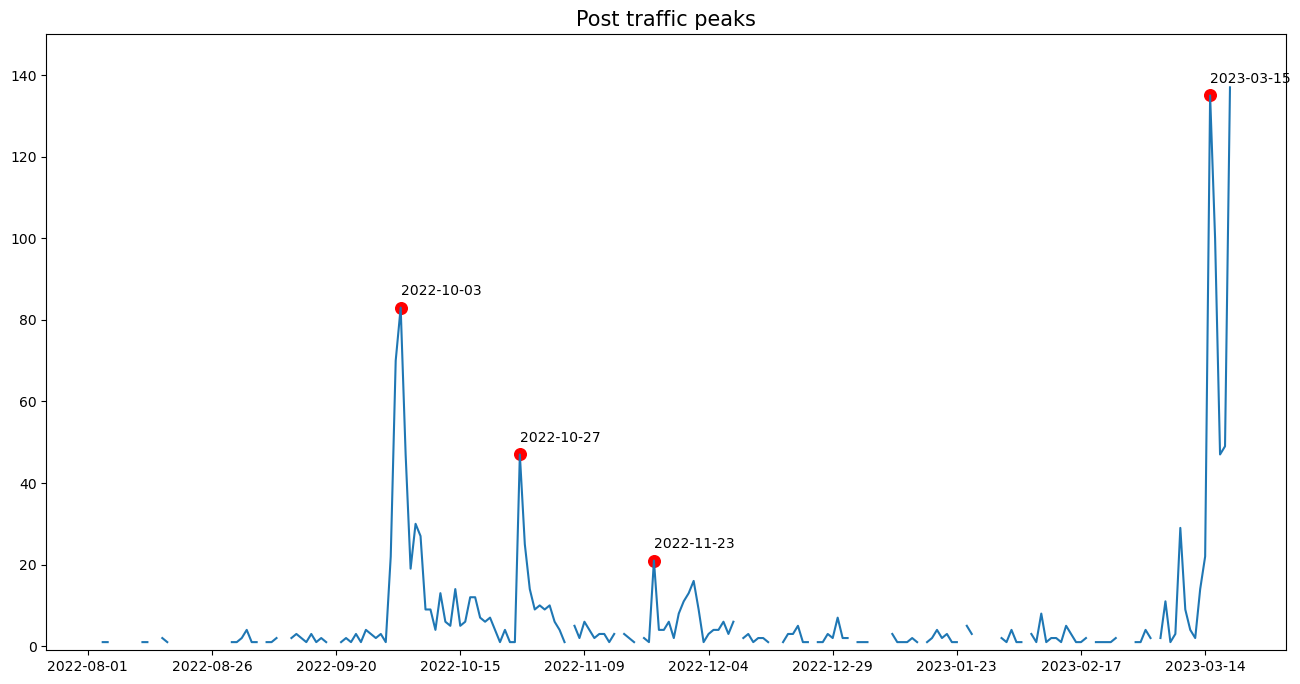

In [ ]:
peaks = ['2022-10-03', '2022-10-27', '2022-11-23', '2023-03-15']
i_coord = [63, 87, 114, 226]
y_coord = [83, 47, 21, 135]
daily = pd.read_csv('Dailydata.csv')
daily['date'] = pd.to_datetime(daily['date']).dt.date
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(daily.index, daily['posts'])
ax.scatter(i_coord, y_coord, c='red', s=70)
for i,y in zip(i_coord, y_coord):
    sentiment = np.round(daily.loc[i, 'sentiment'],2)
    date = daily.loc[i, 'date']
    ax.text(i,y+3, date, fontsize=10)
ax.set_ylim(-1, 150)
ax.set_title('Post traffic peaks', fontsize=15)
ax.set_xticks(np.arange(0, 226, 25))
ax.set_xticklabels([daily.loc[i, 'date'] for i in np.arange(0, 226, 25)])
plt.show()

#### Correlation between number of posts and stock prices

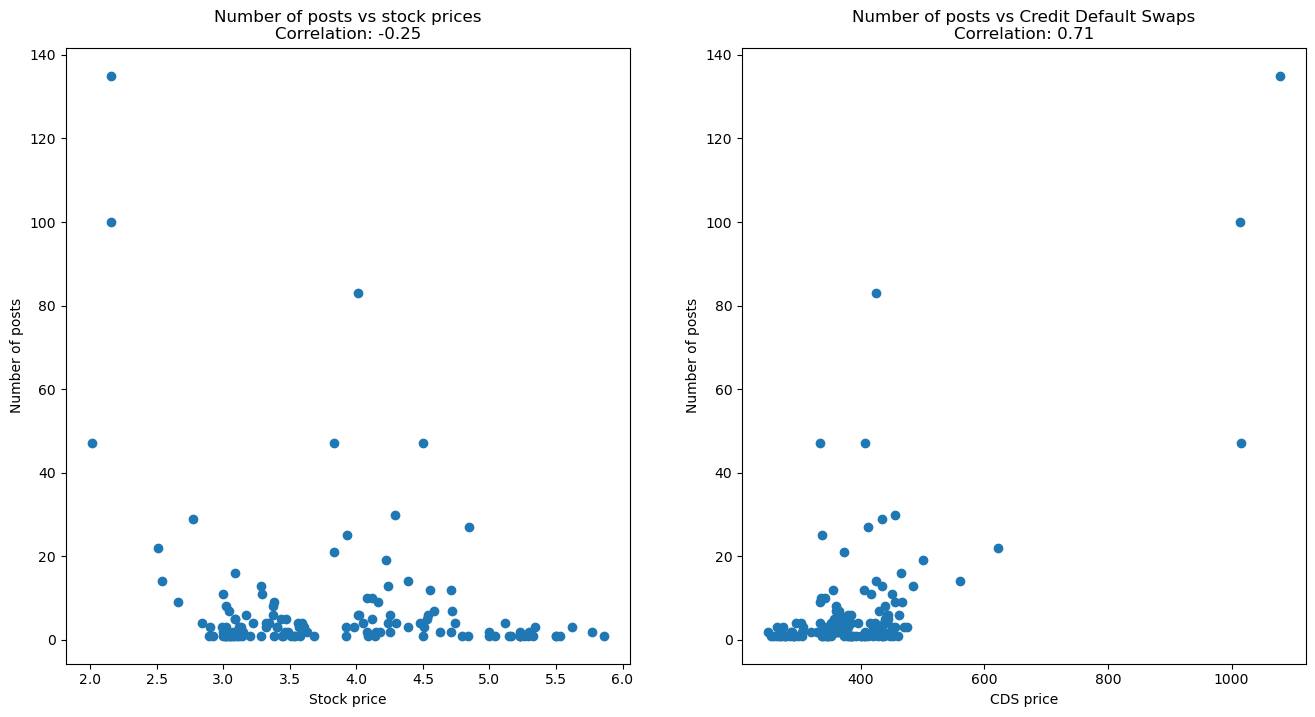

In [ ]:
daily.dropna(inplace=True)
coef1 = np.round(np.corrcoef(daily['price'], daily['posts'])[0,1], 2)
coef2 = np.round(np.corrcoef(daily['cds'], daily['posts'])[0,1], 2)

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].scatter(daily['price'], daily['posts'])
ax[0].set_xlabel('Stock price')
ax[0].set_ylabel('Number of posts')
ax[0].set_title(f"Number of posts vs stock prices\nCorrelation: {coef1}")
ax[1].scatter(daily['cds'], daily['posts'])
ax[1].set_xlabel('CDS price')
ax[1].set_ylabel('Number of posts')
ax[1].set_title(f"Number of posts vs Credit Default Swaps\nCorrelation: {coef2}")
plt.show()

#### Multiple Regression
The number of daily posts published on reddit is correlated (OLS multiple regression) against the stock prices, the volumes traded, the volatility (difference between maximum and minimum price traded in a single day), and cds (the price of Credit Suisse's Credit Default Swap). We decide to use prices instead of percentage returns because when considering prices the coefficient is significant while, when considering returns, it is not significant.

The R2 is very high, 0.757, meaning that the financial data of Credit Suisse clearly explain the behaviour of the posts traffic. Moreover, all the explanatory variables are significant at 95% significance level.

In [ ]:
# Regression setting
X = daily[['price', 'volume', 'volatility', 'cds']]
X = sm.add_constant(X)
Y = daily['posts']
reg = sm.OLS(Y, X)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  posts   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     104.4
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           1.77e-39
Time:                        12:54:10   Log-Likelihood:                -476.14
No. Observations:                 134   AIC:                             962.3
Df Residuals:                     129   BIC:                             976.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.6211      8.760     -4.181      0.0

#### Pre and post peak activity
We investigate if it is possible to get some results when comparing the post made before the 4 peaks of Reddit activity and the posts made after the peaks. It is considered a time windows of 5 days (1 work week). Therefore, all the posts made 5 days before the 4 peaks are aggregated in a single dataset, and the same is done with the posts made 5 days after (including the one of the peak). Instead of the peak 2023-03-15, it is chosen 2023-03-09, because it represents the beginning of both high traffic activity and stock price decline.

The mean sentiment and the mean return are computed for both sets. Then, 2 regression model, one for pre-peak data and one for post-peak data, are set up. The variables are the same as before: features realted to posts are fitted against financial returns.

In terms of descriptive statistic there is a difference between the mean sentiment and the mean return between the two sets, but the same result can't be reached on the basis of the linear regressions (both low R2). At least, the post-peak model has a better explanatory power (highest R2, lowest BIC and AIC) than pre-peak model.

In [ ]:
peaks = pd.to_datetime(['2022-10-03', '2022-10-27', '2022-11-23', '2023-03-09']).date
window = 5
daily = pd.read_csv('Dailydata.csv')
daily.dropna(inplace=True)
daily['date'] = pd.to_datetime(daily['date']).dt.date
daily.sort_values('date', inplace=True)
df_pre = []
df_post = []
for p in peaks:
    df_pre.append(daily[daily['date']<p].tail(window))
    df_post.append(daily[daily['date']>=p].head(window))
df_pre = pd.concat(df_pre, ignore_index=True)
df_post = pd.concat(df_post, ignore_index=True)
print('Sentiment pre:', df_pre['sentiment'].mean())
print('Sentiment post:', df_post['sentiment'].mean())
print('Returns pre:', df_pre['returns'].mean())
print('Returns post:', df_post['returns'].mean())

Sentiment pre: 0.1718744751082251
Sentiment post: -0.0013958091224725824
Returns pre: -0.005219524300335029
Returns post: -0.020031298638652436


In [ ]:
X = df_pre[['sentiment', 'posts', 'karma', 'upvote']]
X = sm.add_constant(X)
Y = df_pre['returns']
reg = sm.OLS(Y, X)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                 -0.131
Method:                 Least Squares   F-statistic:                    0.4513
Date:                Fri, 01 Sep 2023   Prob (F-statistic):              0.770
Time:                        19:35:49   Log-Likelihood:                 44.597
No. Observations:                  20   AIC:                            -79.19
Df Residuals:                      15   BIC:                            -74.22
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0552      0.128      0.433      0.6

In [ ]:
X = df_post[['sentiment', 'posts', 'karma', 'upvote']]
X = sm.add_constant(X)
Y = df_post['returns']
reg = sm.OLS(Y, X)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     2.393
Date:                Fri, 01 Sep 2023   Prob (F-statistic):             0.0968
Time:                        19:35:49   Log-Likelihood:                 28.607
No. Observations:                  20   AIC:                            -47.21
Df Residuals:                      15   BIC:                            -42.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6884      0.611      2.763      0.0

### 3.4 Short selling
The last analysis concerns Short

In [ ]:
bim = pd.read_csv('Shortdata.csv')
bim = StandScal(bim)
X = bim[['karma', 'upvote', 'length', 'sentiment', 'posts', 'price']]
X = sm.add_constant(X)
Y = bim['shares']
reg = sm.OLS(Y, X)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 shares   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     4.477
Date:                Fri, 01 Sep 2023   Prob (F-statistic):             0.0225
Time:                        19:35:51   Log-Likelihood:                -11.128
No. Observations:                  16   AIC:                             36.26
Df Residuals:                       9   BIC:                             41.66
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.776e-17      0.162  -1.72e-16      1.0

C:\Users\cuogh\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 4 Word Embedding

### 4.1 WordCount Vectorization

In [ ]:
# Import the dataset
df = pd.read_csv('Sentdata.csv', index_col=0)
stock = pd.read_csv('CS.csv', index_col=0)
stock = stock.pct_change()
stock.dropna(inplace=True)

# Word Vectorizer aggregated per day
corpus = [df.loc[i, 'text'] for i in df.index]
vectorizer = CountVectorizer()
one_hot_encoded = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()
onehot = pd.DataFrame(one_hot_encoded.toarray(), columns=features,
                          index=pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d'))

penalty = 0
onehot.drop(onehot.columns[(onehot.sum(axis=0) < penalty)], axis=1, inplace=True)
onehot

,aa,aaaaannndd,aapl,aar,aaron,ab,aback,abandon,abate,abatement,...,zoltan,zombie,zoom,zscaler,zu,zuckerburg,zum,zurich,zuvor,zzero
date,,,,,,,,,,,,,,,,,,,,,
2022-10-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-10-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


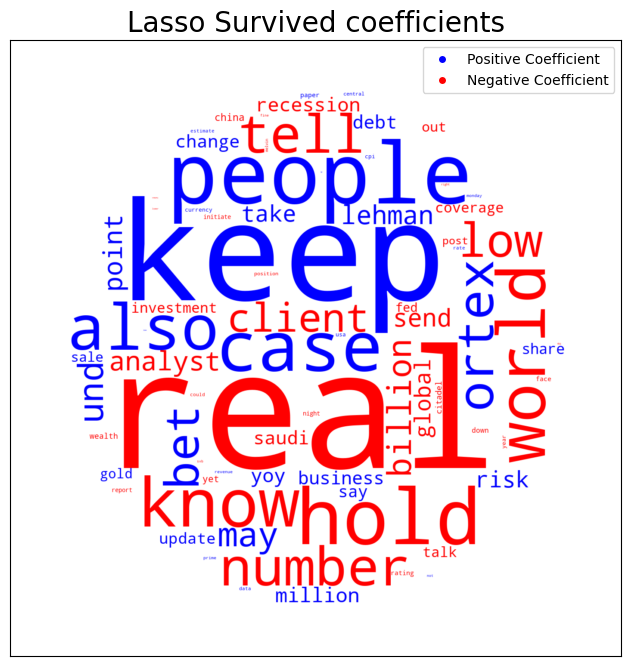

In [ ]:
# Lasso Regression for Variable Selection

# Colors for wordclouds
def get_color(value):
    return 'blue' if value >= 0 else 'red'

ts_word = onehot.groupby(onehot.index).sum()
X = ts_word.loc[daily['date'].astype('str')]
Y = daily['returns']
reg = Lasso(alpha=0.01, max_iter=10000).fit(X, Y)
survivors = pd.DataFrame(reg.coef_, onehot.columns, columns=['coef'])
coeffic = survivors[survivors['coef']!=0]['coef']
word_colors = {word: get_color(value) for word, value in zip(coeffic.index, coeffic)}
fig, ax = plt.subplots(figsize = (16,8))
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1,
                      color_func=lambda word, *args, **kwargs: word_colors[word])
wordcloud.generate_from_frequencies(dict(coeffic**2))
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_title('Lasso Survived coefficients', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='Positive Coefficient'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Negative Coefficient')]
ax.legend(handles=legend_elements, loc='upper right')
plt.show()

### 4.2 Tf-Idf Vectorizer

In [ ]:
# Tf-idf matrix
corpus = [df.loc[i, 'text'] for i in df.index]
vectorizer = TfidfVectorizer()
tfidf_encoded = vectorizer.fit_transform(corpus)
features = vectorizer.get_feature_names_out()
tfidf = pd.DataFrame(tfidf_encoded.toarray(), columns=features,
                    index=pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d'))
tfidf

,aa,aaaaannndd,aapl,aar,aaron,ab,aback,abandon,abate,abatement,...,zoltan,zombie,zoom,zscaler,zu,zuckerburg,zum,zurich,zuvor,zzero
date,,,,,,,,,,,,,,,,,,,,,
2022-10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-10-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-03-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


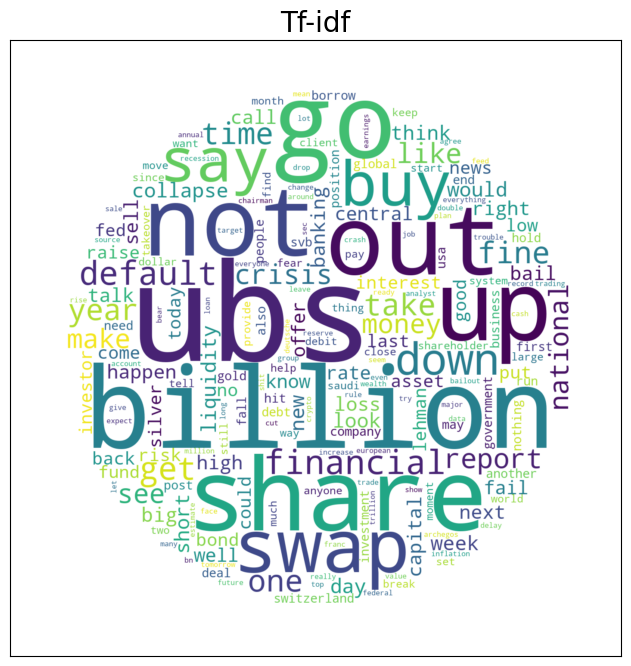

In [ ]:
# Tf-idf
fig, ax = plt.subplots(figsize = (16,8))
wordcloud = WordCloud(background_color="white", mask=imask, random_state=1)
wordcloud.generate_from_frequencies(dict(tfidf.sum()))
ax.imshow(wordcloud, interpolation="bilinear")
ax.set_title('Tf-idf', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### 4.3 Word2vec

In [ ]:
# Word2vec embedding
corpus = [word_tokenize(df.loc[i, 'text']) for i in df.index]
w2v = Word2Vec(corpus, min_count=1, vector_size=300)

In [ ]:
w2v.wv.most_similar('hold', topn=10)

[('firm', 0.9999350905418396),
 ('investment', 0.9999276399612427),
 ('business', 0.9999266862869263),
 ('security', 0.9999262094497681),
 ('investor', 0.9999261498451233),
 ('plan', 0.9999258518218994),
 ('also', 0.9999246597290039),
 ('loss', 0.9999235272407532),
 ('cash', 0.9999231696128845),
 ('mean', 0.9999223351478577)]

In [ ]:
daily

,date,posts,price,volume,volatility,karma,upvote,length,sentiment,cds,returns
3,2022-08-04,-0.401669,1.908122,-0.394229,-0.510410,-0.241738,0.686948,-0.370991,1.872703,-1.105401,True
4,2022-08-05,-0.401669,1.873674,-0.398329,-0.186775,-0.403957,0.950067,-0.426597,-0.443170,-1.067114,True
11,2022-08-12,-0.401669,2.287056,-0.452833,-0.834045,-0.394945,0.160710,-0.432952,0.520656,-1.177721,True
15,2022-08-16,-0.344410,2.183711,-0.396159,-0.402531,-0.403957,0.950067,-0.424214,-0.135668,-1.220262,True
16,2022-08-17,-0.401669,1.873674,-0.380242,-0.402531,-0.404601,0.950067,0.229562,-1.003400,-1.152196,False
...,...,...,...,...,...,...,...,...,...,...,...
224,2023-03-13,0.342700,-1.525247,0.459740,0.568374,-0.156444,0.317328,-0.418880,-0.971843,1.417295,False
225,2023-03-14,0.800773,-1.559695,0.298882,-0.294653,-0.134294,0.180643,-0.277615,-0.545063,1.949061,False
226,2023-03-15,7.271057,-1.961595,9.604765,3.481091,-0.077283,-0.011455,-0.308593,-0.244265,5.831206,False
227,2023-03-16,5.266987,-1.961595,4.769140,0.568374,0.084979,-0.119951,-0.186344,-0.076906,5.276297,True
